In [1]:
import sys,os
import lowpass
import cv2
assert cv2.__version__[0] == '3', 'The fisheye module requires opencv version >= 3.0.0'
import numpy as np
import threading
import Queue
import time
from matplotlib import pyplot as plt
import math
import scipy

In [162]:

def homomorphic_filter(img):
    '''
    Code adapted from here :
    https://sites.google.com/site/bazeilst/tutorials#TUTO9
    As adapted from here :
    https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
    '''
    print('Entering homomorphic filter')
    start = time.time()
    sstart = time.time()
    rows,cols = img.shape
        
    rh, rl, cutoff = 2.5,0.5,32

    y  = img

    y_log = np.log(y+0.01)
    tconvert = time.time() - start
    print("time to compute first log %s", tconvert )


    start = time.time()
    y_fft = np.fft.fft2(y_log)

    y_fft_shift = np.fft.fftshift(y_fft)
    tconvert = time.time() - start
    print("time to compute fft %s", tconvert )

    start = time.time()
    DX = cols/cutoff
    G = np.ones((rows,cols))
    for i in range(rows):
        for j in range(cols):
            G[i][j]=((rh-rl)*(1-np.exp(-((i-rows/2)**2+(j-cols/2)**2)/(2*DX**2))))+rl

    tconvert = time.time() - start
    print("time to compute for loop %s", tconvert )

    start = time.time()
    result_filter = G * y_fft_shift
    tconvert = time.time() - start
    print("time to compute result filter %s", tconvert )

    start = time.time()
    result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter)))
    tconvert = time.time() - start
    print("time to compute third fft %s", tconvert )

    start = time.time()
    result = np.exp(result_interm)
    y = np.float32(result)


    tconvert = time.time() - start
    print("time to convert image back %s", tconvert )

    tconvert = time.time() - sstart
    print("time to DO ALL %s", tconvert )
    return y

In [214]:
def fast_homomorphic_filter(img):
    '''
    Code adapted from here :
    https://sites.google.com/site/bazeilst/tutorials#TUTO9
    As adapted from here :
    https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
    '''
    print('Entering homomorphic filter')
    start = time.time()
    sstart = time.time()
    rows,cols = img.shape
        
    rh, rl, cutoff = 2.5,0.5,32

    y  = img
    
    n = 100000.0
    y_log = n* (((y) ** (1/n)) - 1)
    tconvert = time.time() - start
    print("time to compute first log %s", tconvert )


    start = time.time()
    # Check size for dft optimization
    nrows = cv2.getOptimalDFTSize(rows)
    ncols = cv2.getOptimalDFTSize(cols)

    nimg = np.zeros((nrows,ncols))
    nimg[:rows,:cols] = y_log
    # Do the DFT itself
    y_fft= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
    y_fft_shift = np.fft.fftshift(y_fft)
    print("time to compute fft %s", tconvert )


    start = time.time()
    DX = cols/cutoff

    G = []
    n = 1000000
    G = [(-((i-nrows/2)**2+(j-ncols/2)**2)) for i in range (nrows) for j in range (ncols)]
    H = np.asarray(G)/(2*DX**2)
    H = H/n
    H = (1-(1+H)**n)
    H = H*(rh-rl)
    H = H +rl
    H = np.reshape(H,(nrows,ncols))
    
    tconvert = time.time() - start
    print("time to compute for loop %s", tconvert )

    start = time.time()
    dft_complex = y_fft_shift[:,:,1] + y_fft_shift[:,:,0]*1j
    result_filter = H * dft_complex
    tconvert = time.time() - start
    print("time to compute result filter %s", tconvert )

    start = time.time()
    idft_flags = cv2.DFT_COMPLEX_OUTPUT| cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT
    
    result_split = np.ndarray(y_fft_shift.shape)
    result_split[:,:,0] = result_filter.imag
    result_split[:,:,1] = result_filter.real

    result_interm = cv2.idft(np.fft.ifftshift(result_split),flags = idft_flags)
    tconvert = time.time() - start
    print("time to compute third fft %s", tconvert )

    start = time.time()
    result = np.exp(result_interm)
    y = np.float32(result[0:rows,0:cols])


    tconvert = time.time() - start
    print("time to convert image back %s", tconvert )

    tconvert = time.time() - sstart
    print("time to DO ALL %s", tconvert )
    return y

In [215]:
def fast_homomorphic_filter2(img):
    '''
    Code adapted from here :
    https://sites.google.com/site/bazeilst/tutorials#TUTO9
    As adapted from here :
    https://dsp.stackexchange.com/questions/42476/homomorphic-filter-python-overflow
    '''
    print('Entering homomorphic filter')
    start = time.time()
    sstart = time.time()
    rows,cols = img.shape
        
    rh, rl, cutoff = 2.5,0.5,32

    y  = img

    n = 100000.0
    y_log = n* (((y) ** (1/n)) - 1)
    tconvert = time.time() - start
    print("time to compute first log %s", tconvert )


    start = time.time()
    y_fft = np.fft.fft2(y_log)

    y_fft_shift = np.fft.fftshift(y_fft)
    tconvert = time.time() - start
    print("time to compute fft %s", tconvert )

    start = time.time()
    DX = cols/cutoff

    
    G = []
    G = [(-((i-rows/2)**2+(j-cols/2)**2)) for i in range (rows) for j in range (cols)]
    H = np.asarray(G)/(2*DX**2)
    H = H/n
    H = (1-(1+H)**n)
    H = H*(rh-rl)
    H = H +rl
    H = np.reshape(H,(rows,cols))

    tconvert = time.time() - start
    print("time to compute for loop %s", tconvert )

    start = time.time()
    result_filter = H * y_fft_shift
    tconvert = time.time() - start
    print("time to compute result filter %s", tconvert )

    start = time.time()
    result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter)))
    tconvert = time.time() - start
    print("time to compute third fft %s", tconvert )

    start = time.time()
    result = np.exp(result_interm)
    y = np.float32(result)


    tconvert = time.time() - start
    print("time to convert image back %s", tconvert )

    tconvert = time.time() - sstart
    print("time to DO ALL %s", tconvert )
    return y

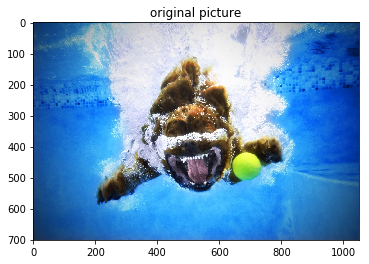

In [3]:
p = cv2.imread('dog.jpg',3)
RGB_im = np.float32(cv2.cvtColor(p, cv2.COLOR_BGR2RGB))/255
plt.imshow(RGB_im)
plt.title('original picture')
plt.show()

In [4]:
img = np.float32(p)
img = img/255
        
img  = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

y = img[:, :, 0]
u = img[:, :, 1]
v = img[:, :, 2]

In [5]:
rows,cols = y.shape
rh, rl, cutoff = 2.5,0.5,32
rows,cols

(701, 1050)

### Logarithm function

#### With numpy

In [6]:
%timeit y_log = np.log(y+0.01)

10 loops, best of 3: 18.6 ms per loop


#### With math

In [7]:
%%%timeit
y_log2 = []
for el in y:
    for pix in el:
        y_log2.append(math.log(pix+0.01))

1 loop, best of 3: 2.34 s per loop


#### With scipy

Requires square functions, we divide the img in squares

In [8]:
shape = y.shape
minval = np.amin(shape)
y_copy = y[0:minval,0:minval]
print y_copy.shape

(701, 701)


In [9]:
%timeit y_log3 = scipy.linalg.logm(y_copy)

logm result may be inaccurate, approximate err = 8.11954383935e-06
logm result may be inaccurate, approximate err = 8.11954383935e-06
logm result may be inaccurate, approximate err = 8.11954383935e-06
logm result may be inaccurate, approximate err = 8.11954383935e-06
1 loop, best of 3: 9.35 s per loop


#### Taylor approximation

In [10]:
print np.amax(y)

1.0


In [11]:
%%%timeit
x = y+0.01
log = (x-1) - (x-1)**2/2 + (x-1)**3/3

10 loops, best of 3: 58.5 ms per loop


lets check error!!

In [12]:
y_log = np.log(y+0.01)

x = y+0.01
log = (x-1) - (x-1)**2/2

print y_log[100][100]
print log[100][100]

A = log
B = y_log
mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

-1.04603
-0.859057


0.059605181

#### Limit

In [142]:
def lnlm(x):
    n = 10000.0
    x = np.asarray(x)
    return n * ((x ** (1/n)) - 1)

In [14]:
print lnlm(0.5)
print lnlm(math.e)
a = [0.5, math.e, 1]
print lnlm(a)

-0.692907009547
1.00050016671
[-0.69290701  1.00050017  0.        ]


In [144]:
%%%timeit
n = 10000
limlog = n* ((y ** (1/n)) - 1)

The slowest run took 4.72 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 804 µs per loop


In [183]:
y_log = np.log(y+0.01)

limlog = lnlm(y+0.01)

print y_log[100][100]
print limlog[100][100]

A = limlog
B = y_log
mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

-1.04603
-1.04606


3.4580896e-08

### Fourier transform

Help with this in https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_transforms/py_fourier_transform/py_fourier_transform.html
theory http://www.lip.uns.edu.ar/pdi/32.htm

#### Without DFT Optimization

##### Numpy

In [17]:
%%%timeit
f = np.fft.fft2(limlog)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

1 loop, best of 3: 672 ms per loop


In [18]:
f = np.fft.fft2(limlog)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

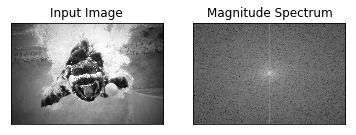

In [19]:
plt.subplot(121),plt.imshow(y, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

##### OpenCV

In [20]:
%%%timeit
dft = cv2.dft(np.float32(limlog),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

100 loops, best of 3: 14.2 ms per loop


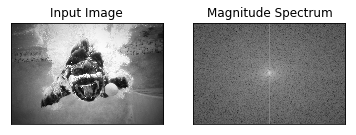

In [21]:
dft = cv2.dft(np.float32(limlog),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)
magnitude_spectrum2 = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))
plt.subplot(121),plt.imshow(y, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum2, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()

error

In [22]:
A = magnitude_spectrum
print A.shape
B = magnitude_spectrum2
print B.shape

print A[100][100]
print B[100][100]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(701, 1050)
(701, 1050)
56.8916459658
56.8916


1.412227886251395e-08

#### With DFT optimization

Obtain optimal size of image

In [23]:
rows,cols = limlog.shape
print rows,cols

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)
print nrows, ncols

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

701 1050
720 1080


##### Numpy

In [24]:
%%%timeit
rows,cols = limlog.shape

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

fft2 = np.fft.fft2(nimg)
fshift2 = np.fft.fftshift(fft2)
magnitude_spectrum4 = 20*np.log(np.abs(fshift2))

1 loop, best of 3: 93.1 ms per loop


In [25]:
fft2 = np.fft.fft2(nimg)
fshift2 = np.fft.fftshift(fft2)
magnitude_spectrum4 = 20*np.log(np.abs(fshift2))

##### OpenCV

In [26]:
%%%timeit
rows,cols = limlog.shape

nrows = cv2.getOptimalDFTSize(rows)
ncols = cv2.getOptimalDFTSize(cols)

nimg = np.zeros((nrows,ncols))
nimg[:rows,:cols] = limlog

dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift2 = np.fft.fftshift(dft2)
magnitude_spectrum3 = 20*np.log(cv2.magnitude(dft_shift2[:,:,0],dft_shift2[:,:,1]))

10 loops, best of 3: 28.4 ms per loop


In [27]:
dft2= cv2.dft(np.float32(nimg),flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift2 = np.fft.fftshift(dft2)
magnitude_spectrum3 = 20*np.log(cv2.magnitude(dft_shift2[:,:,0],dft_shift2[:,:,1]))

In [28]:
A = magnitude_spectrum4
print A.shape
B = magnitude_spectrum3
print B.shape

print A[100][100]
print B[100][100]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(720, 1080)
(720, 1080)
44.4755876814
44.4757


1.1751181392645686e-08

### High pass filter

#### Manually creating it

In [29]:
print fshift2
print fshift2.shape
print fshift2.dtype

[[ -7.32636452 -1.42108547e-14j   1.43840811 +7.22081483e+00j
    1.56956237 -1.29141033e+01j ...,  -6.21109877 +2.97661782e-01j
    1.56956237 +1.29141033e+01j   1.43840811 -7.22081483e+00j]
 [  7.13253660 -2.87995773e-01j  -5.58543922 -4.51151695e+00j
    6.38609108 +1.29008169e+01j ...,   9.55360508 +1.74217828e+00j
   -6.64182632 -8.97719120e+00j   1.19665343 +1.09959207e+01j]
 [  2.73030625 -5.50214700e+00j   3.22991568 +1.11819577e+01j
   -6.23916863 -7.21579127e+00j ...,  -2.21833435 -1.10176240e+00j
    1.84655424 -1.07531816e+00j  -1.47772634 +5.74264593e+00j]
 ..., 
 [-10.91055913 -1.46234911e+01j   4.67009054 +1.77551302e+01j
   -1.40166540 -7.72419315e+00j ...,  -2.65137160 +1.57300805e+00j
    1.61821697 -2.10948995e+00j   4.42454578 +1.47815125e+01j]
 [  2.73030625 +5.50214700e+00j  -1.47772634 -5.74264593e+00j
    1.84655424 +1.07531816e+00j ...,   4.29760759 -6.24897786e+00j
   -6.23916863 +7.21579127e+00j   3.22991568 -1.11819577e+01j]
 [  7.13253660 +2.87995773e-01j  

In [30]:
DX = ncols/cutoff
G = np.ones((nrows,ncols))

In [31]:
%%%timeit
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=((rh-rl)*(1-np.exp(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))))+rl

result_filter = G * fshift2

1 loop, best of 3: 3.26 s per loop


In [32]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-np.e**(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 1.16 s per loop


In [33]:
def exp_taylor(x):
    return 1+x+x**2/2+x**3/3+x**4/24+x**5/120+x**6/720+x**7/5040

print np.e**5
print exp_taylor(5)

148.413159103
147


In [34]:
def exp_lim(x):
    n = 10000
    return (1+x/n)**n

print np.e**5
print exp_lim(5.0)

148.413159103
148.227820292


In [35]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-exp_taylor(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 1.85 s per loop


In [36]:
%%%timeit
G = np.ones((nrows,ncols))
G = G*(rh-rl)
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-exp_lim(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G +rl
result_filter = G * fshift2

1 loop, best of 3: 1.06 s per loop


In [37]:
def map_explim(x):
    wx = x[0]**2
    wy = x[1]**2
    
    exp = -(wx+wy)/(2*DX**2)
    
    return exp_lim(exp)

In [38]:
%%%timeit
G = []
G = [(i,j) for i in range (nrows) for j in range (ncols)]
H = map(lambda x: map_explim(x), G)
H = 1-np.asarray(H)
H = H*(rh-rl)
H = H +rl

1 loop, best of 3: 963 ms per loop


In [39]:
%%%timeit
G = []
G = [(i,j) for i in range (nrows) for j in range (ncols)]
H = map(lambda x: exp_lim(-(x[0]**2+x[1]**2)/(2*DX**2)), G)
H = 1-np.asarray(H)
H = H*(rh-rl)
H = H +rl

1 loop, best of 3: 843 ms per loop


In [40]:
%%%timeit
G = []
G = [exp_lim(-(i**2+j**2)/(2*DX**2)) for i in range (nrows) for j in range (ncols)]
H = 1-np.asarray(G)
H = H*(rh-rl)
H = H +rl

1 loop, best of 3: 659 ms per loop


In [201]:
%%%timeit
G = []
n = 10000
G = [(-(i**2+j**2)) for i in range (nrows) for j in range (ncols)]
H = np.asarray(G)/(2*DX**2)
H = H/n
H = (1-(1+H)**n)
H = H*(rh-rl)
H = H +rl
H = np.reshape(H,(nrows,ncols))

1 loop, best of 3: 385 ms per loop


In [42]:
G = np.ones((nrows,ncols))
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-np.e**(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
        
G = G*(rh-rl)
G = G +rl

F = np.ones((nrows,ncols))
for i in range(nrows):
    for j in range(ncols):
        F[i][j]=1-exp_lim(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
F = F*(rh-rl)
F = F +rl



A = G
print A.shape
B = F
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(720, 1080)
(720, 1080)
2.5
2.5


0.0055090048508016597

In [213]:
G = np.ones((nrows,ncols))
for i in range(nrows):
    for j in range(ncols):
        G[i][j]=1-np.e**(-((i-nrows/2)**2+(j-ncols/2)**2)/(2*DX**2))
G = G*(rh-rl)
G = G +rl

A = G

F = []
n = 100000.0
F = [(-((i-nrows/2)**2+(j-ncols/2)**2)) for i in range (nrows) for j in range (ncols)]
H = np.asarray(F,dtype=np.float64)/(2.0*DX**2)
H = H/n
H = (1-(1+H)**n)
H = H*(rh-rl)
H = H +rl
H = np.reshape(H,(nrows,ncols))



print A.shape
B = H
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(720, 1080)
(720, 1080)
2.5
2.5


0.0041732243668904387

In [44]:
print fshift2[700][200]
print G[700][200]
print H[700][200]
result_filter1 = G * fshift2

result_filter2 = H * fshift2

A = np.real(result_filter1)
print A.shape
B = np.real(result_filter2)
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(23.2570961801-1.29907991006j)
2.5
2.5
(720, 1080)
(720, 1080)
58.1427404502
58.1427404502


1695522.8273416678

#### With OpenCV array

I need to convert the two-channel opencv array to one-channel with complex numbers

In [45]:
dft_complex = dft_shift2[:,:,1] + dft_shift2[:,:,0]*1j
dft_complex

array([[ -7.32778931 -9.53674316e-07j,   1.43839741 +7.22097683e+00j,
          1.56949544 -1.29140587e+01j, ...,  -6.21107340 +2.97868729e-01j,
          1.56949544 +1.29140587e+01j,   1.43839741 -7.22097683e+00j],
       [  7.13292933 -2.88306236e-01j,  -5.58560705 -4.51153994e+00j,
          6.38610172 +1.29005461e+01j, ...,   9.55379581 +1.74194813e+00j,
         -6.64159870 -8.97711182e+00j,   1.19647455 +1.09960728e+01j],
       [  2.73059607 -5.50277138e+00j,   3.22988129 +1.11821909e+01j,
         -6.23923159 -7.21560097e+00j, ...,  -2.21856070 -1.10166311e+00j,
          1.84646988 -1.07545614e+00j,  -1.47783303 +5.74256611e+00j],
       ..., 
       [-10.91082573 -1.46238546e+01j,   4.67016888 +1.77552338e+01j,
         -1.40174401 -7.72389507e+00j, ...,  -2.65127134 +1.57298660e+00j,
          1.61815071 -2.10982990e+00j,   4.42439175 +1.47813148e+01j],
       [  2.73059368 +5.50276947e+00j,  -1.47783303 -5.74256611e+00j,
          1.84646988 +1.07545614e+00j, ...,   4.29765

In [46]:
%timeit dft_complex = dft_shift2[:,:,1] + dft_shift2[:,:,0]*1j

100 loops, best of 3: 3.19 ms per loop


In [47]:
A = fshift2
B = dft_complex


print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(23.2570961801-1.29907991006j)
(23.2571-1.29903j)


(3.1219980228032974e-09-3.8161147808020593e-11j)

In [48]:
print G[700][200]
print H[700][200]
result_filter3 = G * dft_complex

result_filter4 = H * dft_complex

A = result_filter2
print A.shape
B = result_filter4
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

2.5
2.5
(720, 1080)
(720, 1080)
(58.1427404502-3.24769977515j)
(58.1427145004-3.2475733757j)


(1.9496823879024596e-08-2.3852814196508499e-10j)

#### Laplacian filtering

Why is laplacian Kernel a high pass filter?

The Laplacian kernel is like this:

In [49]:
laplacian=np.array([[0, 1, 0],
                    [1,-4, 1],
                    [0, 1, 0]])

Let's plot it:

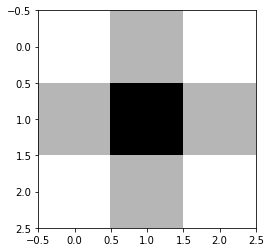

In [50]:
fft_filters = np.fft.fft2(laplacian) 
fft_shift = np.fft.fftshift(fft_filters)
mag_spectrum = np.log(np.abs(fft_shift)+1)

plt.imshow(mag_spectrum,cmap = 'gray')
plt.show()

From image, you can see what frequency region each kernel blocks(black), and what region it passes(white). 

#### High pass filter

After applying the fftshift function we've got the lower frequencies in the center, so we can simply turn the first elements of the matrix to zero. In this with a window of 60x60

In [114]:
%%%timeit
crow,ccol = nrows/2 , ncols/2
dft_shift2_copy = dft_shift2.copy()
dft_shift2_copy[crow-15:crow+15, ccol-15:ccol+15,0] = 0
dft_shift2_copy[crow-15:crow+15, ccol-30:ccol+15,1] = 0

1000 loops, best of 3: 827 µs per loop


In [134]:
crow,ccol = nrows/2 , ncols/2
dft_shift2_copy = dft_shift2.copy()
dft_shift2_copy[crow-5:crow+5, ccol-5:ccol+5,0] = 0
dft_shift2_copy[crow-5:crow+5, ccol-5:ccol+5,1] = 0

### Inverse Fourier Transform

#### Numpy

In [55]:
%timeit result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter4)))

10 loops, best of 3: 37.8 ms per loop


In [89]:
result_interm = np.real(np.fft.ifft2(np.fft.ifftshift(result_filter4)))


#### OpenCV

According to OpenCV documentation on the cv2.idft function: http://docs.opencv.org/modules/core/doc/operations_on_arrays.html#idft . There is a note at the end of it, which says:

    Note: None of dft and idft scales the result by default. So, you should pass DFT_SCALE to one of dft or idft explicitly to make these transforms mutually inverse.

So, when calling idft, it is necessary to pass the cv2.DFT_SCALE flag. 

In [90]:
idft_flags = cv2.DFT_COMPLEX_OUTPUT| cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT

In [91]:
result_split = np.ndarray(dft_shift2.shape)
result_split[:,:,0] = result_filter4.imag
result_split[:,:,1] = result_filter4.real

result_interm2 = cv2.idft(np.fft.ifftshift(result_split),flags = idft_flags)

In [94]:
%%%timeit
result_split = np.ndarray(dft_shift2.shape)
result_split[:,:,0] = result_filter4.imag
result_split[:,:,1] = result_filter4.real

result_interm2 = cv2.idft(np.fft.ifftshift(result_split),flags = idft_flags)

10 loops, best of 3: 18.1 ms per loop


In [93]:
A = result_interm
print A.shape
B = result_interm2
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(720, 1080)
(720, 1080)
-2.76205976469
-2.76205976469


1.2970915037506276e-29

#### OpenCV + Simply HPF

In [135]:
result_interm3 = cv2.idft(np.fft.ifftshift(dft_shift2_copy),flags = idft_flags)

### Reverse Logarithm Transform with exponential

In [108]:
%timeit result = np.exp(result_interm2)

10 loops, best of 3: 27.7 ms per loop


In [109]:
%timeit result2 = exp_lim(result_interm2)

10 loops, best of 3: 52.6 ms per loop


In [110]:
%timeit result3 = (1+result_interm2/n)**n

10 loops, best of 3: 52 ms per loop


In [111]:
result = np.exp(result_interm2)

In [112]:
result2 = exp_lim(result_interm2)

In [113]:
A = result
print A.shape
B = result2
print B.shape

print A[700][200]
print B[700][200]

mse = (np.square(A - B)).mean(axis=None)

# Mean squared error
mse

(720, 1080)
(720, 1080)
0.0631615363797
0.0631374436522


3.7926525500708111e-10

In [120]:
j = result[0:rows,0:cols]

Populating the interactive namespace from numpy and matplotlib


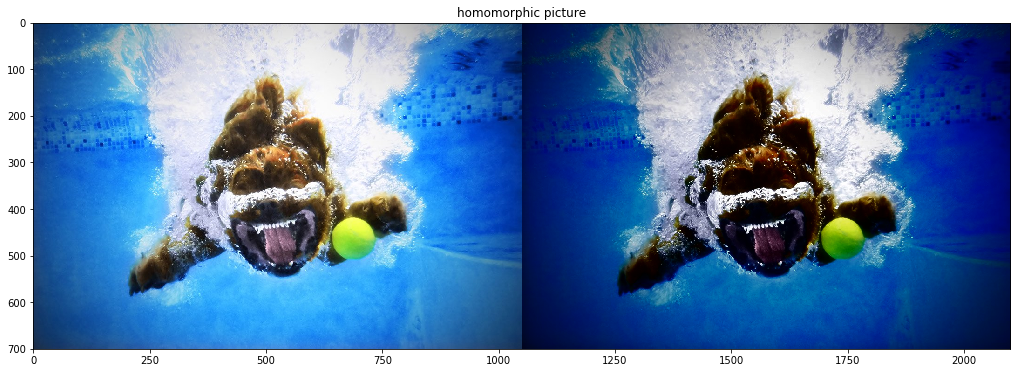

In [121]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

merged = cv2.merge((np.float32(j),u,v))
imgf  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

#### Custom Simply HPF

In [133]:
%timeit result2 = np.exp(result_interm3)

10 loops, best of 3: 23.1 ms per loop


In [136]:
result3 = np.exp(result_interm3)
#k = np.float32(result2)
k_original_size = result3[0:rows,0:cols]
k_original_size.shape

(701, 1050)

Populating the interactive namespace from numpy and matplotlib


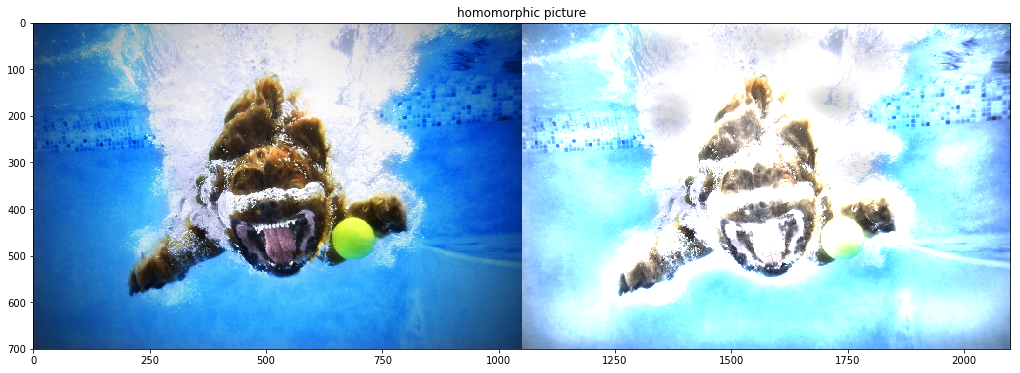

In [137]:
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 6)

merged2 = cv2.merge((k_original_size,u,v))
imgf2  = cv2.cvtColor(merged2,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

In [138]:
%%%timeit
otra = homomorphic_filter(y)

Entering homomorphic filter
('time to compute first log %s', 0.029942035675048828)
('time to compute first fft %s', 0.6931538581848145)
('time to compute second fft %s', 0.006671905517578125)
('time to compute for loop %s', 3.692888021469116)
('time to compute result filter %s', 0.002705097198486328)
('time to compute third fft %s', 0.6858999729156494)
('time to convert image back %s', 0.02526378631591797)
('time to DO ALL %s', 5.1439127922058105)
Entering homomorphic filter
('time to compute first log %s', 0.01598191261291504)
('time to compute first fft %s', 0.6150350570678711)
('time to compute second fft %s', 0.008950948715209961)
('time to compute for loop %s', 3.9083127975463867)
('time to compute result filter %s', 0.0028219223022460938)
('time to compute third fft %s', 0.6983699798583984)
('time to convert image back %s', 0.024698972702026367)
('time to DO ALL %s', 5.275984048843384)
Entering homomorphic filter
('time to compute first log %s', 0.015685081481933594)
('time to co

Entering homomorphic filter
('time to compute first log %s', 0.03837394714355469)
('time to compute fft %s', 0.9136929512023926)
('time to compute for loop %s', 4.198761940002441)
('time to compute result filter %s', 0.0029239654541015625)
('time to compute third fft %s', 0.6516830921173096)
('time to convert image back %s', 0.028330087661743164)
('time to DO ALL %s', 5.835530996322632)


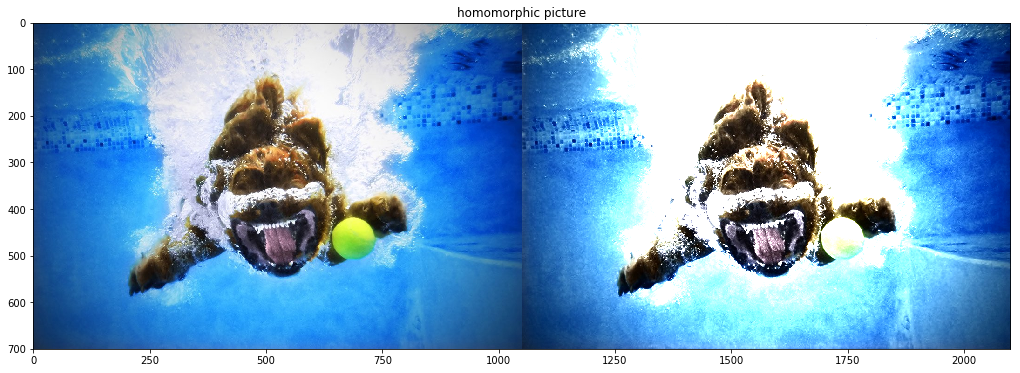

In [189]:
otra = homomorphic_filter(y)
merged = cv2.merge((otra,u,v))
imgf2  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()

Entering homomorphic filter
('time to compute first log %s', 0.11608099937438965)
('time to compute fft %s', 0.11608099937438965)
('time to compute for loop %s', 0.6779258251190186)
('time to compute result filter %s', 0.00778508186340332)
('time to compute third fft %s', 0.025106191635131836)
('time to convert image back %s', 0.026231050491333008)
('time to DO ALL %s', 0.8811969757080078)


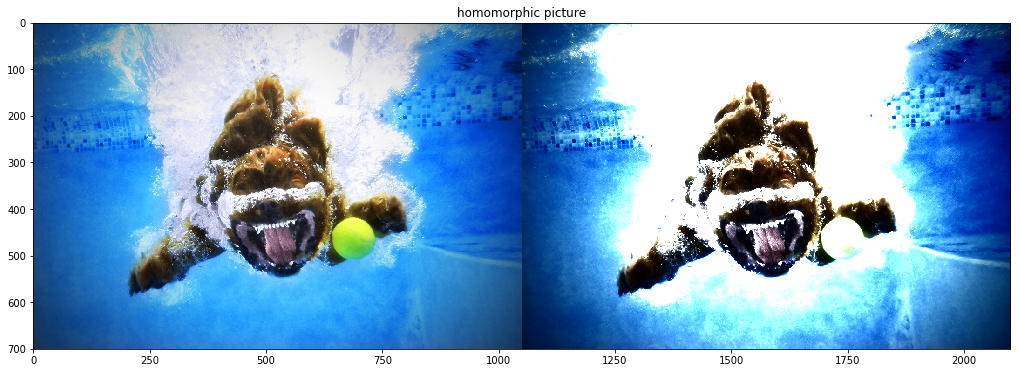

In [218]:
otra = fast_homomorphic_filter(y)
merged = cv2.merge((otra,u,v))
imgf2  = cv2.cvtColor(merged,cv2.COLOR_YUV2RGB)
res = np.hstack((RGB_im, imgf2))
plt.imshow(res)
plt.title('homomorphic picture')
plt.show()